# Part 0 - Background

The ambulance simulation will be implemented using a schedule-based simulation. 

The reason for using a schedule based simulation is that it allows us to track the state of the system throughout time and order events to occur similar to the actual system.

The schedule and event class are both copies of the code provided during the first week of class and will not be explained into detail. 

In [1]:
#import all packages
import heapq
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import random
import networkx as nx
import pandas as pd
%matplotlib inline

In [2]:
class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        # Return the time of the next event. The `now` attribute of this class
        # contain the time of the last event that was run.
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        # Print out diagnostic information about the events in the schedule.
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

# Part 1 - City, Area, and Ambulance Station classes

City - The city class is the main class for the simulation. It represent the city for which the implementation is made for (Stockholm). 

The city class allocates the ambulances, tracks the response time to each call. It allocates an ambulance by finding the nearest ambulance station from the region which the call came from. The response time for each call is determined directly the ambulance is allocated. The city class also holds a undirected network consisting of nodes, where each node holds a region object which represents a region within Stockholm. The edges represent connections between region and will be weigted depending of the size of the connecting regions. The city class also hold a dictionary of stations objects, each with the name of the region it is within.

The region class contains methods for scheduling a call to the city object. Each call corresponds to a emergency in where an ambulance needs to be send. The interval between each call will be linearly proportional to the population in the area. Each region also contain its name, and the distibution for which the interval between calls will be scheduled from.

The station class holds information of the current number of ambulances available at the station, along with how many ambulances is allocated to the station. It also holds information to the history of the number of ambulances at the station.

It's assumed that the rate at which calls arrive is proportional to the population of the area. Population statistics is gathered from the municipality of sim = City("Stockohlm", area_data, station_data_30_30_30, tot_call_rate = 1)
sim.observe()Stockholm (see link). Information of the number of ambulances and the location for the ambulance stations are gathered from the ambulance contractors website (See link)

Statistics inhabitants - https://start.stockholm/globalassets/start/om-stockholms-stad/utredningar-statistik-och-fakta/statistik/omradesfakta/socioekonomiska-faktablad/folkmangd-och-utlandsk-bakgrund.pdf

Ambulances - https://www.aisab.nu/sv-se/om-oss/vara-ambulansstationer

A summary of key statistics is presented below.

Total population: 971 465
-----------------------
Rinkeby-Kista: 51 266 

Spånga-Tensta: 38 929

Hässelby-Vällingby: 76 573

Bromma: 80 725

Kungsholmen: 71 264

Norrmalm: 73 331

Östermalm: 78 358

Södermalm 131 124

Enskede-Årsta-Vantör: 102 828

Skarpnäck: 46 467

Farsta: 59 523

Hägersten-Älvsjö: 123 259

Skärholmen: 37 818

Ambulances 
------------------------
Total ambulances: 90

There are a total of 3 ambulance stations within these 13 regions

Ambulance stations: Norrmalm - Enskede/Årsta/Vantör - Spånga/Tensta

Annual Ambulance alarms per 1000 inhabitants in stockholm (2020): 46.3

Calls per 24 h: 123 (Seems a bit low to me)

In [3]:
class City:
    """This is the city class, and it tracks the history of all the emergency calls in the city region. 
    It also allocates which ambulance station should respond to the emergency.
    
    Methods
    --------
    initialize_network: Initializes the network all the regions and the edges connecting neighbouring regions. 
                        The weight of each edge is the sum of the size category for each region.
    initialize_stations: Initializes the ambulance stations in the region with their name and their number of allocated ambulances.
    observe: Print out the network.
    arriving_call: Allocate incoming emergency calls and compute the response time. It also schedules a later arrival of the ambulance.
    
    Attributes
    ---------
    name: The name of the city
    tot_call_rate: The total call rate for the entire city
    g: Network of the regions
    g.pos: Position of the regions (For printing the network)
    stations: Dictionary of all the ambulance stations
    responses: List of response history
    call_backlog: List holding all the calls put on hold
    
    """
    
    def __init__(self, city_name, network_data, station_data, tot_call_rate = 1):
        
        self.name = city_name
        self.tot_call_rate = tot_call_rate
        self.g = self.initialize_network(network_data)
        self.g.pos = nx.spring_layout(self.g, seed = 12)
        self.stations = self.initialize_stations(station_data)
        self.responses = []
        self.call_backlog = []
        
    def initialize_network(self, network_data):
        """This method initialize a network of all the regions in a networkx graph
        It starts by adding nodes for all the regions, each node hold a region object. It then connects 
        all the nodes with weighted edges. The edge weight is the sum of the size of the area
        
        Parameters
        ---------
        network_data: Dictionary with information about the population, neighouring regions, and size for all the regions"""
        
        #Create a empty graph
        g = nx.Graph() 
        
        #Adds all the regions to the graph
        for region_name in network_data.keys(): #Loop though all the region names
            g.add_node(region_name) #Add a node
            
            #Add a region object to each node
            g.nodes[region_name]["region"] = city_region(region_name, sts.expon(scale = 1/(network_data[region_name][0]*self.tot_call_rate)))
            
        #Connect all the cities
        for region_name in network_data.keys():
            
            #Go through each connection for the region
            for edge in network_data[region_name][1]: 
                
                #Connect the regions and add a weight to the edge
                g.add_edge(region_name, edge, weight = network_data[region_name][2] + network_data[edge][2])
                
        return g
    
    def initialize_stations(self, station_data):
        """This method initializes all the ambulance stations in te city. 
        It creates a new dictionary and add the station names as keys and the elements are ambulance station objects
        
        Parameters
        ---------
        station_data: Dictionary with the information about the number of allocated ambulances to each station"""
        
        #dict to hold the station instances
        stations = {}
        
        #add all the stations
        for station in station_data.keys():
            
            #adds a station object/instance to each key
            stations[station] = Amb_station(station, station_data[station], self)
            
        return stations
    
    def observe(self):
        """This method prints out the network"""
        plt.figure(figsize=(8,8)) 
        labels = nx.get_edge_attributes(self.g, 'weight')
        nx.draw(self.g, pos=self.g.pos, with_labels = True)
        nx.draw_networkx_edge_labels(self.g, pos = self.g.pos, edge_labels=labels)
        plt.show()
        
    
    def arriving_call(self, schedule, region, backlog_time = 0):
        """The arriving call method is the heart if this class. The method recives an emergency call from a region
           It then find the closes region with available ambulances which is sent to the region. It computes 
           the time needed to respond to the call as the shortest distance between the region and the station with a added random variable
           accounting for the time needed to find the person in need. After that is schedules the arrival of the ambulance to the station.
           If (Which should never happen) all ambulances are out in service, it stores the call in the backlog and sends out an ambulance
           as soon as there is one available"""


        #If there are available ambulances
        if sum([self.stations[station].curr_amb for station in self.stations.keys()]) > 0:

            shortest_stat_dist = np.inf #Placeholder for shortest distance

            for station in self.stations.keys(): #Go through all stations

                stat_dist = nx.dijkstra_path_length(self.g, station, region) #find the distance from station to region

                if self.stations[station].curr_amb > 0 and stat_dist <= shortest_stat_dist: #check if the station has ambulances and if it's close to the region

                    #If station is equally close, but has less available ambulances, send out from the previous station
                    if (stat_dist == shortest_stat_dist and 
                        self.stations[station].curr_amb < self.stations[amb_station].curr_amb): 
                        
                        continue

                    else:
                        shortest_stat_dist = stat_dist
                        amb_station = station
            
            #Send out an ambulance from the department
            self.stations[amb_station].depart_amb() 

            #shortest distance to travel plus a random number from a gamma that represent time to get to client
            response_time = shortest_stat_dist + sts.gamma(a = 2, scale = 0.5).rvs()

            #time to assist the client at site, truncated normal at 0.5 with mean 2 and sd 1
            assist_time = sts.truncnorm(a = (0.5-3)/1, b = (20-3)/1, loc = 2, scale = 1).rvs()

            #Time until back at the station
            use_time = response_time*2 + assist_time

            #append the reponse time (with backlog_time if applicable) and which region to response history
            self.responses.append([region, response_time + backlog_time])
            
            #Add the arriving ambulance at an interval
            schedule.add_event_after(use_time, self.stations[amb_station].arrive_amb)

            #schedule a new call from the region if the call wasn't from the backlog
            if backlog_time == 0:
                self.g.nodes[region]["region"].schedule_call(self, schedule)
            
        else: #if no amabulances are available, add to the backlog of calls

            #append the call to the backlog queue
            self.call_backlog.append([region, schedule.now]) 
            
            #schedule a new call from the region
            self.g.nodes[region]["region"].schedule_call(self, schedule)
        

class city_region:
    """This is the region class. The class holds a method for scheduling the new emergency call to the city.
    The next emergency call is scheduled at an interval drawn from a 
    exponential distribution with a call rate proportional to it's number of inhabitants. 
    
    Attributes
    ----------
    Name: The name of the region
    call_dist: The exponential distribution from which the interval to next arrival is drawn"""
    
    def __init__(self, name, call_dist):
        
        self.name = name
        self.call_dist = call_dist
        
    
    def schedule_call(self, sim, schedule):
        """This methods schedules a call to the emergency call center. It schedules it at an interval drawn from a exponential distribution"""
        
        #This method schedules a call for an ambulance to the city. Schedules with interval from a random sample from the call_dist
        
        interval = self.call_dist.rvs() #Find the time for next call
        
        schedule.add_event_after(interval, sim.arriving_call, self.name) #Schedule the next call
        

class Amb_station:
    """This is the ambulance station class. The class holds methods for arriving (increase available ambulances) and departing
    ambulances (Decrease available ambulances)
    
    Attributes
    ----------
    name: Name of the region for the station.
    max_amb: The maximum number of ambulances for the station.
    curr_amb: The current number of ambulances.
    city: The city instance that holds the station - Helps the station check if there is any backlogs.
    amb_hist: The historty of the number of ambulances at the station throughout time.
    """
    
    def __init__(self, name, ambulances, city):
        
        self.name = name 
        self.max_amb = ambulances
        self.curr_amb = ambulances
        self.city = city
        self.amb_hist = []
        
    def depart_amb(self):
        """Departs one ambulance by reducing the current number of amulances by one. Also saves to the history"""
        
        #depart ambulance
        self.curr_amb += -1
        
        #add to history
        self.amb_hist.append(self.curr_amb)
        
        
    def arrive_amb(self, schedule):
        """Arrives one ambulance by increase the current number of amulances by one. Also saves to the history.
        If there is any backloged calls, the ambulance is send out directly to the emergency call by calling the arriving call method"""
        
        #arrive ambulance
        self.curr_amb += 1
        
        #add to history
        self.amb_hist.append(self.curr_amb)
        
        #check if there is a backlog of calls, if so, send out directly
        if len(self.city.call_backlog) > 0:
            
            #get the backlog information
            call_info = self.city.call_backlog.pop(0)
            
            #Send out an ambulance right away
            self.city.arriving_call(schedule, call_info[0], schedule.now - call_info[1])         

In [4]:
area_data = {
"Rinkeby-Kista": [51266/971465, ["Spånga-Tensta", "Solna"], 2],
"Spånga-Tensta": [38929/971465, ["Rinkeby-Kista", "Hässelby-Vällingby", "Bromma"], 2],
"Hässelby-Vällingby": [76573/971465, ["Spånga-Tensta", "Bromma"], 3],
"Bromma": [80725/971465, ["Hässelby-Vällingby", "Spånga-Tensta", "Solna", "Kungsholmen", "Hägersten-Älvsjö"], 3],
"Kungsholmen": [71264/971465, ["Bromma", "Solna", "Norrmalm", "Södermalm", "Hägersten-Älvsjö"], 1],
"Norrmalm": [73331/971465, ["Östermalm", "Södermalm", "Kungsholmen", "Solna"], 1],
"Östermalm": [78358/971465, ["Norrmalm", "Södermalm", "Solna"], 3],
"Södermalm": [131124/971465, ["Norrmalm", "Östermalm", "Kungsholmen", "Hägersten-Älvsjö", "Enskede-Årsta-Vantör", "Skarpnäck"], 2],
"Enskede-Årsta-Vantör": [102828/971465, ["Södermalm", "Hägersten-Älvsjö", "Farsta", "Skarpnäck"], 2],
"Skarpnäck": [46467/971465, ["Farsta", "Enskede-Årsta-Vantör", "Södermalm"], 3],
"Farsta": [59523/971465, ["Skarpnäck", "Enskede-Årsta-Vantör"], 2],
"Hägersten-Älvsjö": [123259/971465, ["Skärholmen", "Bromma", "Kungsholmen", "Södermalm", "Enskede-Årsta-Vantör"], 3],
"Skärholmen": [37818/971465, ["Hägersten-Älvsjö"], 1],
"Solna": [0.00000000000001/971465, ["Rinkeby-Kista", "Spånga-Tensta", "Bromma", "Kungsholmen", "Norrmalm", "Östermalm"], 3]
}

station_data_30_30_30 = {
    "Spånga-Tensta": 30,
    "Norrmalm": 30,
    "Enskede-Årsta-Vantör": 30,
}


### Observe the network

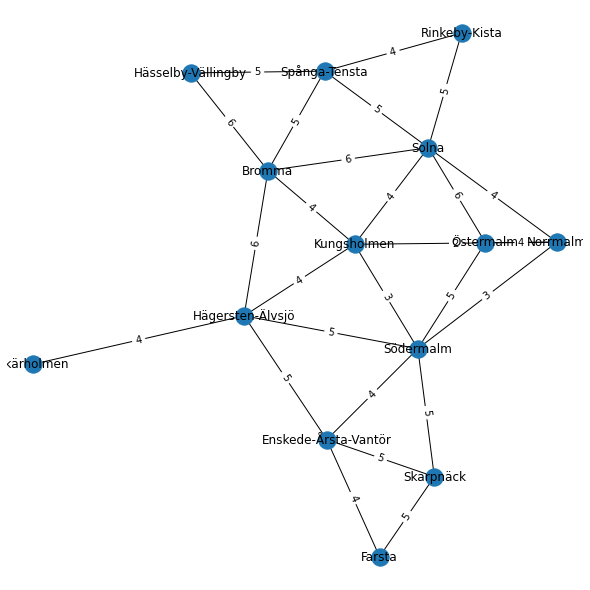

In [5]:
sim = City("Stockohlm", area_data, station_data_30_30_30, tot_call_rate = 1)
sim.observe()

Theoretical analysis: 
-------------
For my theorical analysis, I analyse the relative ambulance load for each station. The relative ambulance load is a combined measurement of the expected number of call to each stations and the expected time needed for taking care of each emergency. 

The relative ambulance load for each station is computed by summing over the product of (1) distance to the regions its closes to, (2) the average time to find and take care of the client, (3) the proportion of all calls coming from that region.

The relative ambulance load is a better indicator of where to allocate the ambulances as oppose to only looking at which stations has the largest population with that perticular station as the closes. This is because the load on the ambulances is also influence by the time needed to respond to a emergency, which is factored for the in the relative ambulance load

In [6]:
def theoretical_analysis(area_data, station_data):
    """Thid function computes the relative ambulance load for each station"""
    
    #create a network
    sim = City("Stockohlm", area_data, station_data)
    
    #dictionary to hold the data
    station_load = {}
    
    #create a key for each of the stations
    for station in station_data.keys():
        station_load[station] = 0
    
    #go through each region
    for region in area_data.keys():
        
        #placeholder for minimum distance
        min_dist = np.inf
        
        #check the distance to each of the stations
        for station in station_data.keys():
            
            #Find the distance
            stat_dist = nx.dijkstra_path_length(sim.g, station, region)
            
            #See whether it's the current closes
            if stat_dist < min_dist:
                min_dist = stat_dist
                min_station = station
        
        #compute the relative ambulance load for that region (E[X] for the truncated normal is approximatly 2.02)
        weight_time = (2*(min_dist+1)+2.02) * area_data[region][0]
        
        #sum for the closes station
        station_load[min_station] += weight_time
    
    #print the results
    print(f"""The relative ambulance load for each station is:  
    Spånga-Tensta: {station_load['Spånga-Tensta']:.2f}
    Norrmalm: {station_load['Norrmalm']:.2f}
    Enskede-Årsta-Vantör: {station_load['Enskede-Årsta-Vantör']:.2f}""")    

In [7]:
def plot_waiting_time(region, data, title):
    """Plots the waiting time distribution"""
    
    plt.hist(data, density = True, bins = 15)
    plt.title(title + region)
    plt.show()
    
def plot_amb_history(station, data, title):
    """Plots the ambulance history for one simulation"""
    
    plt.plot(np.arange(len(data)), data)
    plt.ylabel("Available ambulances")
    plt.xlabel("Time")
    plt.xticks([])
    plt.title(title + station)
    plt.ylim([0,30])
    plt.show()

In [8]:
def run_experiment(area_data, station_data, nr_simulations = 10, plot_wait = False, plot_amb = False, run_until = 200, tot_call_rate = 5.5):
    """This function runs multiple experiments for a certain distribution of ambulances and record two metrices.
    
    (1): For each simulation, the average waiting for for emergency responses for each region and for the entire city.
    (2): For each simulation, the number of times an ambulance station has no available ambulances
    """
    
    #dictionary to hold the average waiting time
    average_sim_data_region = {"Stockholm": []}
    
    #append all the regions
    for region in area_data.keys():
        average_sim_data_region[region] = []
        
    #dictionary for the station history
    sim_data_station = {"Spånga-Tensta": [],
                        "Norrmalm": [],
                        "Enskede-Årsta-Vantör": []}
    
    #conduct all the simulations
    for _ in range(nr_simulations):
        
        #create a simulation
        sim = City("Stockohlm", area_data, station_data, tot_call_rate = tot_call_rate) 
        
        #create a schedule
        schedule = Schedule() 
        
        #schedule calls for all the regions
        for region_name in sim.g:
            sim.g.nodes[region_name]["region"].schedule_call(sim, schedule) #schedule a call

        #run the simulation until time has reached the cut-off
        while schedule.next_event_time() < run_until:

            #runs the next event
            schedule.run_next_event()
        
        #create dictionary to hold all the waiting times for the simulation
        sim_data_region = {"Stockholm": []}
        
        #add the regoins
        for region in area_data.keys():
            sim_data_region[region] = []
        
        #Append all the response times
        for datum in sim.responses:
            sim_data_region[datum[0]].append(datum[1])
            sim_data_region["Stockholm"].append(datum[1])
        
        #Count all the times the station was emptyy
        for station in sim.stations.keys():
            sim_data_station[station].append(np.count_nonzero(np.array(sim.stations[station].amb_hist)==0))
        
        #append the average waiting time
        for region in sim_data_region.keys():
            average_sim_data_region[region].append(np.mean(sim_data_region[region]))
    
    #if we should plot the available ambulance history for the last simulation
    if plot_amb:
        
        for station in sim.stations.keys():
            
            data = sim.stations[station].amb_hist
            
            plot_amb_history(station, data, "Line plot over available ambulances during 1 simulation at station: ")
    
    #if we should plot the waiting time distribution for the last simulation
    if plot_wait:
        
        for region in sim_data_region.keys():
            plot_waiting_time(region, 
                              sim_data_region[region], 
                              "Histogram over ambulance response time during 1 simulation for region: ")
    
    #remove solna cause empty
    del average_sim_data_region['Solna']     
    
    return average_sim_data_region, sim_data_station
            

Theoretical results: Enskede-Årsta-Vantör is the station with highest ambulance load, followed by Norrmalm, and lastly Spånga-Tensta. We should thus expect that allocating ambulances to Enskede will optimize the waiting time and number of vacancies for the ambulance stationstheoretical_analysis(area_data, station_data_30_30_30)

In [9]:
theoretical_analysis(area_data, station_data_30_30_30)

The relative ambulance load for each station is:  
    Spånga-Tensta: 3.07
    Norrmalm: 3.21
    Enskede-Årsta-Vantör: 4.47


### Conduct one experiment and plot the waiting times and ambulance history

/Users/simonandren/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/simonandren/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


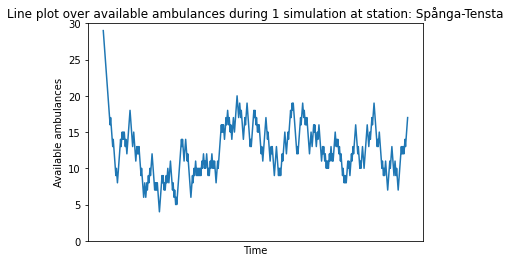

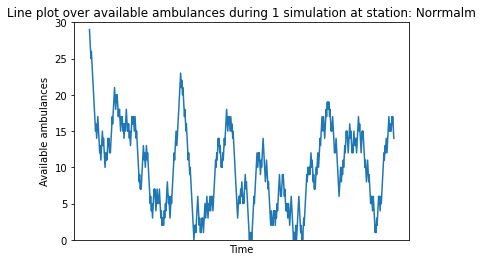

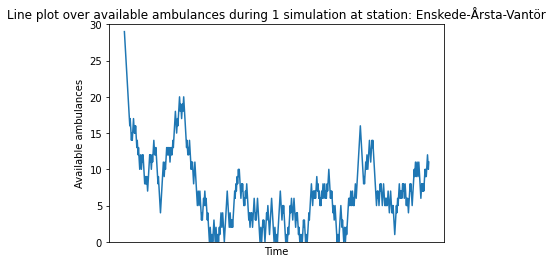

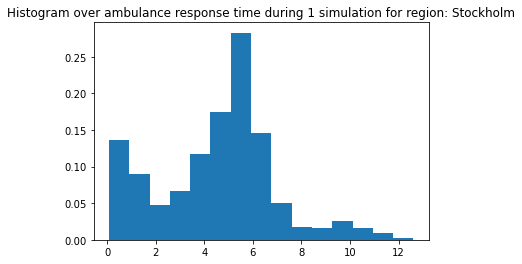

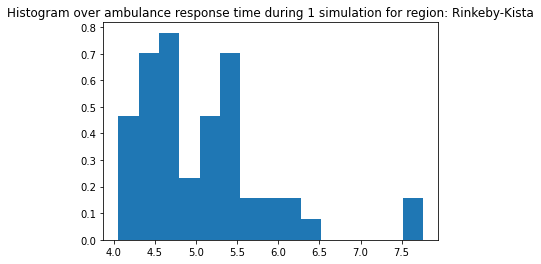

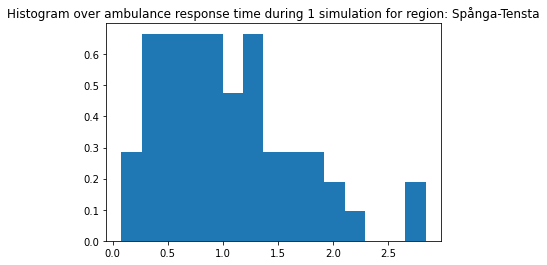

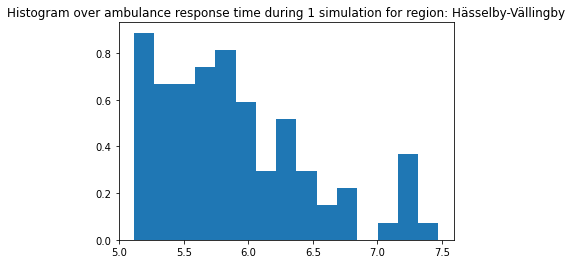

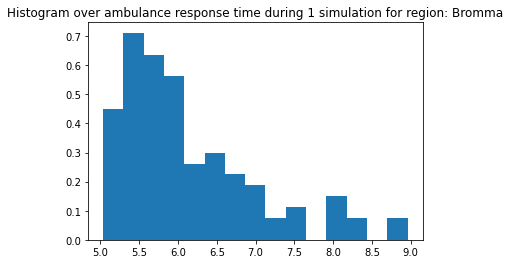

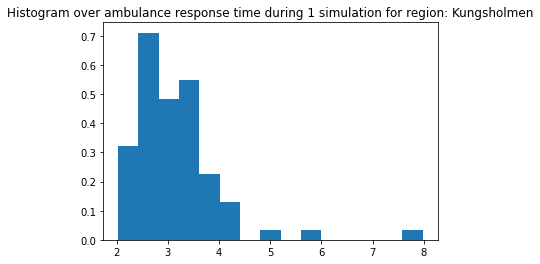

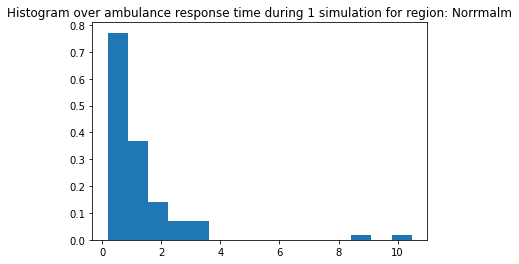

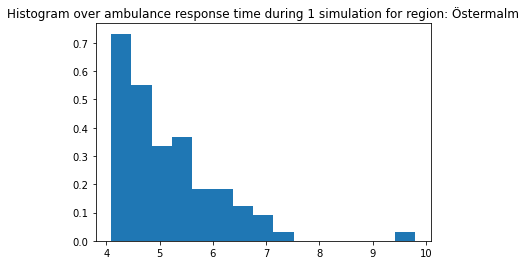

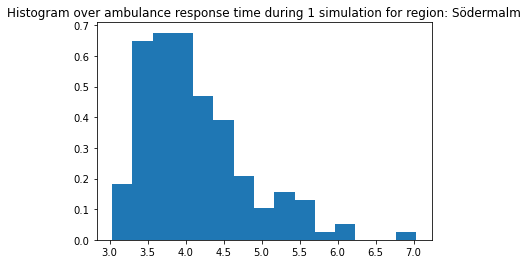

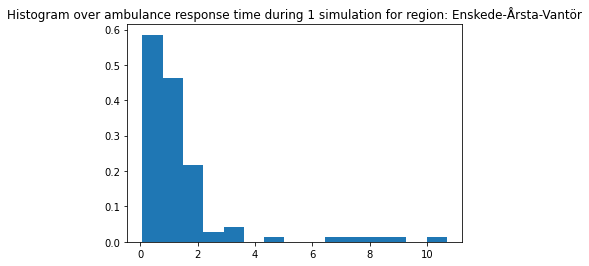

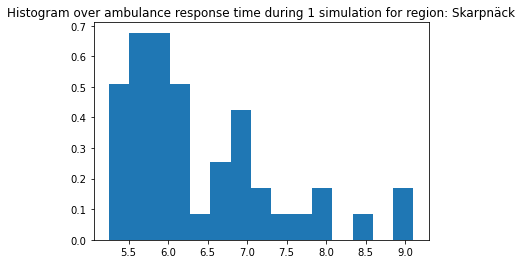

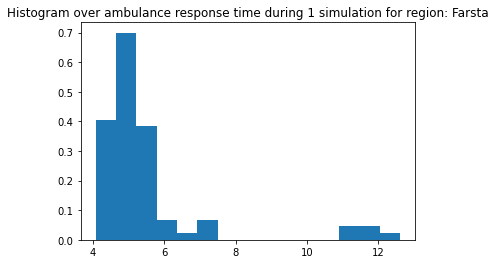

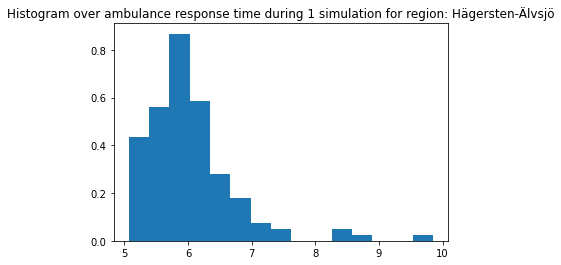

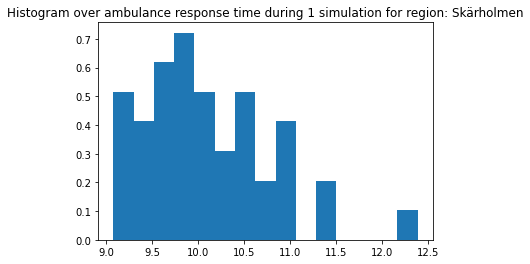

/Users/simonandren/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


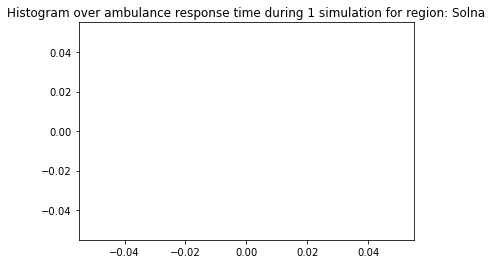

({'Stockholm': [4.522095801108259],
  'Rinkeby-Kista': [5.073341783251182],
  'Spånga-Tensta': [1.033050576894844],
  'Hässelby-Vällingby': [5.8921742331429625],
  'Bromma': [6.126285360613813],
  'Kungsholmen': [3.1439026098421854],
  'Norrmalm': [1.2672531570037917],
  'Östermalm': [5.173130807697967],
  'Södermalm': [4.125657932910365],
  'Enskede-Årsta-Vantör': [1.3967129811526937],
  'Skarpnäck': [6.381315734913448],
  'Farsta': [5.483864966683991],
  'Hägersten-Älvsjö': [6.0376317974589995],
  'Skärholmen': [10.103744236828254]},
 {'Spånga-Tensta': [0], 'Norrmalm': [11], 'Enskede-Årsta-Vantör': [31]})

In [10]:
np.random.seed(1234)
run_experiment(area_data, station_data_30_30_30, nr_simulations = 1, plot_wait = True, plot_amb = True)

As we are hinted to from just one simulation, the spånga-tensta ambulance station has fewer calls in total. When allocating the ambulances equal among the stations, plently of ambulances at spånga-tensta remain stationary. Enskede-Årsta-Vantör however frequently runs our of ambulances. The station to send out ambulances is Enskede is empty is Norrmalm, which probably why Norrmalm recives more calls than expected. 

# Simulation results for different allocations

In [11]:
nr_sim = 500

In [12]:
region_data_1, station_data_1 = run_experiment(area_data, station_data_30_30_30, nr_simulations = nr_sim)

/Users/simonandren/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/simonandren/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


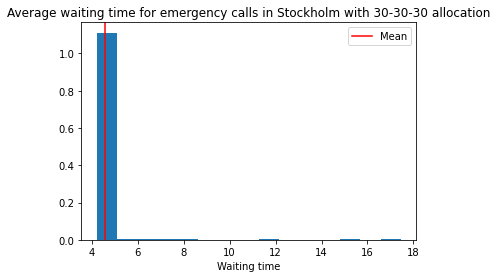

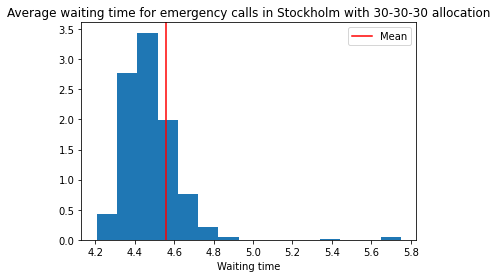

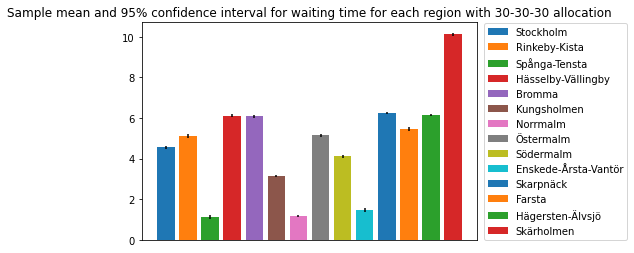

Average number of vacancies for Spånga-Tensta is 2.874 with 95% confidence interval 1.51 - 4.24
Average number of vacancies for Norrmalm is 9.984 with 95% confidence interval 7.80 - 12.17
Average number of vacancies for Enskede-Årsta-Vantör is 26.908 with 95% confidence interval 24.92 - 28.89


In [13]:
#Plot the average waiting time distribution for stockholm
plt.hist(region_data_1["Stockholm"], bins = 15, density = True)
plt.title("Average waiting time for emergency calls in Stockholm with 30-30-30 allocation")
plt.xlabel("Waiting time")
plt.axvline(np.mean(region_data_1["Stockholm"]), label = f"Mean", color = "red")
plt.legend()
plt.show()

#plot around the mode
filter_data = np.array(region_data_1["Stockholm"])
filter_data = filter_data[filter_data < 6]
plt.hist(filter_data, bins = 15, density = True)
plt.title("Average waiting time for emergency calls in Stockholm with 30-30-30 allocation")
plt.xlabel("Waiting time")
plt.axvline(np.mean(region_data_1["Stockholm"]), label = "Mean", color = "red")
plt.legend()
plt.show()

#Create plot for the average waiting time with confidence intervals for each region
i = 0

for region in region_data_1.keys():
    
    #Mean
    mean = np.mean(region_data_1[region])
    
    #standard deviation of the population
    std = np.std(region_data_1[region])/np.sqrt(len(region_data_1[region]))

    #Plot errorbars
    plt.bar(i, mean, yerr = std*1.96, label = region)
    
    i += 1
    
plt.xticks([])
plt.legend(loc = [1.02,0])
plt.title("Sample mean and 95% confidence interval for waiting time for each region with 30-30-30 allocation")
plt.show()

for station in station_data_1.keys():
    confint = sts.t.interval(0.95, len(station_data_1[station])-1,
                             loc=np.mean(station_data_1[station]), scale=sts.sem(station_data_1[station]))
    print(f"Average number of vacancies for {station} is {np.mean(station_data_1[station])} with 95% confidence interval {confint[0]:.2f} - {confint[1]:.2f}")

In [14]:
#With most ambulances in spånga
station_data_50_20_20 = {
    "Spånga-Tensta": 50,
    "Norrmalm": 20,
    "Enskede-Årsta-Vantör": 20,
}
region_data_2, station_data_2 = run_experiment(area_data, station_data_50_20_20, nr_simulations = nr_sim)

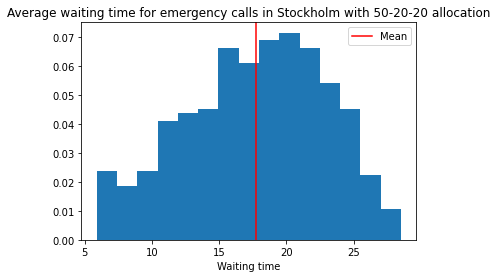

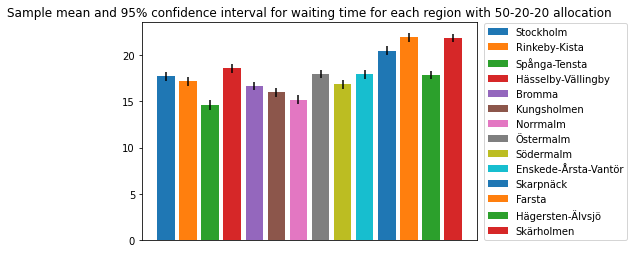

Average number of vacancies for Spånga-Tensta is 267.088 with 95% confidence interval 260.78 - 273.40
Average number of vacancies for Norrmalm is 205.628 with 95% confidence interval 203.37 - 207.89
Average number of vacancies for Enskede-Årsta-Vantör is 183.712 with 95% confidence interval 182.08 - 185.35


In [15]:
#Plot the average waiting time distribution for stockholm
plt.hist(region_data_2["Stockholm"], bins = 15, density = True)
plt.title("Average waiting time for emergency calls in Stockholm with 50-20-20 allocation")
plt.xlabel("Waiting time")
plt.axvline(np.mean(region_data_2["Stockholm"]), label = "Mean", color = "red")
plt.legend()
plt.show()


#Create plot for the average waiting time with confidence intervals for each region
i = 0

for region in region_data_2.keys():
    
    #Mean
    mean = np.mean(region_data_2[region])
    
    #standard deviation of the population
    std = np.std(region_data_2[region])/np.sqrt(len(region_data_2[region]))

    #Plot errorbars
    plt.bar(i, mean, yerr = std*1.96, label = region)
    
    i += 1
    
plt.xticks([])
plt.legend(loc = [1.02,0])
plt.title("Sample mean and 95% confidence interval for waiting time for each region with 50-20-20 allocation")
plt.show()

for station in station_data_2.keys():
    confint = sts.t.interval(0.95, len(station_data_2[station])-1,
                             loc=np.mean(station_data_2[station]), scale=sts.sem(station_data_2[station]))
    print(f"Average number of vacancies for {station} is {np.mean(station_data_2[station])} with 95% confidence interval {confint[0]:.2f} - {confint[1]:.2f}")

In [16]:
#With most ambulances in Norrmalm
station_data_20_50_20 = {
    "Spånga-Tensta": 20,
    "Norrmalm": 50,
    "Enskede-Årsta-Vantör": 20,
}
region_data_3, station_data_3 = run_experiment(area_data, station_data_20_50_20, nr_simulations = nr_sim)

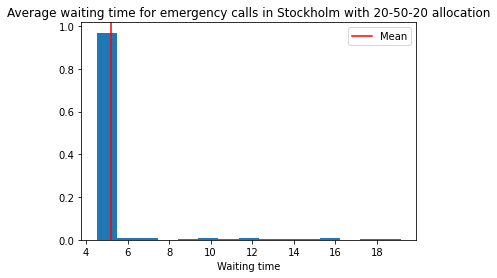

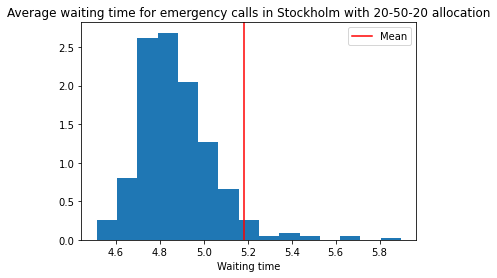

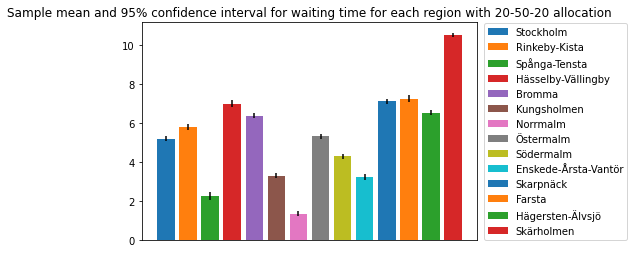

Average number of vacancies for Spånga-Tensta is 32.412 with 95% confidence interval 30.43 - 34.39
Average number of vacancies for Norrmalm is 22.486 with 95% confidence interval 15.20 - 29.77
Average number of vacancies for Enskede-Årsta-Vantör is 93.498 with 95% confidence interval 91.61 - 95.38


In [17]:
#Plot the average waiting time distribution for stockholm
plt.hist(region_data_3["Stockholm"], bins = 15, density = True)
plt.title("Average waiting time for emergency calls in Stockholm with 20-50-20 allocation")
plt.xlabel("Waiting time")
plt.axvline(np.mean(region_data_3["Stockholm"]), label = "Mean", color = "red")
plt.legend()
plt.show()

#plot around the mode
filter_data = np.array(region_data_3["Stockholm"])
filter_data = filter_data[filter_data < 6]
plt.hist(filter_data, bins = 15, density = True)
plt.title("Average waiting time for emergency calls in Stockholm with 20-50-20 allocation")
plt.xlabel("Waiting time")
plt.axvline(np.mean(region_data_3["Stockholm"]), label = "Mean", color = "red")
plt.legend()
plt.show()

#Create plot for the average waiting time with confidence intervals for each region
i = 0

for region in region_data_3.keys():
    
    #Mean
    mean = np.mean(region_data_3[region])
    
    #standard deviation of the population
    std = np.std(region_data_3[region])/np.sqrt(len(region_data_3[region]))

    #Plot errorbars
    plt.bar(i, mean, yerr = std*1.96, label = region)
    
    i += 1
    
plt.xticks([])
plt.legend(loc = [1.02,0])
plt.title("Sample mean and 95% confidence interval for waiting time for each region with 20-50-20 allocation")
plt.show()

for station in station_data_3.keys():
    confint = sts.t.interval(0.95, len(station_data_3[station])-1,
                             loc=np.mean(station_data_3[station]), scale=sts.sem(station_data_3[station]))
    print(f"Average number of vacancies for {station} is {np.mean(station_data_3[station])} with 95% confidence interval {confint[0]:.2f} - {confint[1]:.2f}")

In [18]:
#With most ambulances in Enskede
station_data_20_20_50 = {
    "Spånga-Tensta": 20,
    "Norrmalm": 20,
    "Enskede-Årsta-Vantör": 50,
}
region_data_4, station_data_4 = run_experiment(area_data, station_data_20_20_50, nr_simulations = nr_sim)

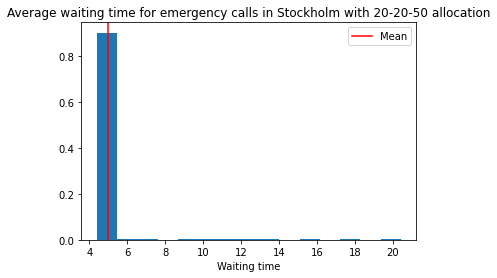

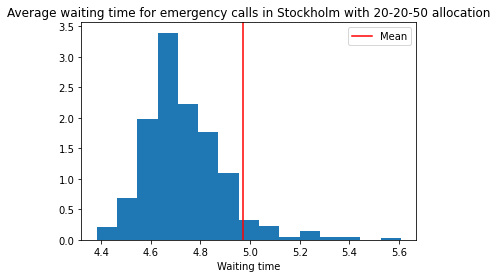

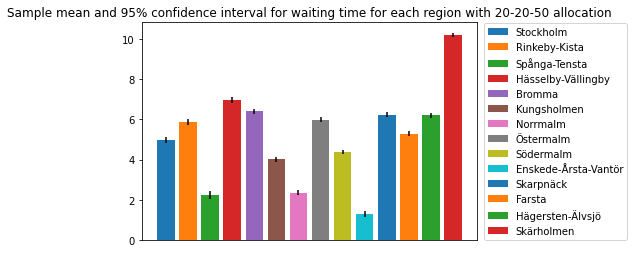

Average number of vacancies for Spånga-Tensta is 29.53 with 95% confidence interval 27.88 - 31.18
Average number of vacancies for Norrmalm is 68.17 with 95% confidence interval 65.93 - 70.41
Average number of vacancies for Enskede-Årsta-Vantör is 13.264 with 95% confidence interval 8.28 - 18.25


In [19]:
#Plot the average waiting time distribution for stockholm
plt.hist(region_data_4["Stockholm"], bins = 15, density = True)
plt.title("Average waiting time for emergency calls in Stockholm with 20-20-50 allocation")
plt.xlabel("Waiting time")
plt.axvline(np.mean(region_data_4["Stockholm"]), label = "Mean", color = "red")
plt.legend()
plt.show()

#plot around the mode
filter_data = np.array(region_data_4["Stockholm"])
filter_data = filter_data[filter_data < 6]
plt.hist(filter_data, bins = 15, density = True)
plt.title("Average waiting time for emergency calls in Stockholm with 20-20-50 allocation")
plt.xlabel("Waiting time")
plt.axvline(np.mean(region_data_4["Stockholm"]), label = "Mean", color = "red")
plt.legend()
plt.show()


#Create plot for the average waiting time with confidence intervals for each region
i = 0

for region in region_data_4.keys():
    
    #Mean
    mean = np.mean(region_data_4[region])
    
    #standard deviation of the population
    std = np.std(region_data_4[region])/np.sqrt(len(region_data_4[region]))

    #Plot errorbars
    plt.bar(i, mean, yerr = std*1.96, label = region)
    
    i += 1
    
plt.xticks([])
plt.legend(loc = [1.02,0])
plt.title("Sample mean and 95% confidence interval for waiting time for each region with 20-20-50 allocation")
plt.show()

for station in station_data_4.keys():
    confint = sts.t.interval(0.95, len(station_data_4[station])-1,
                             loc=np.mean(station_data_4[station]), scale=sts.sem(station_data_4[station]))
    print(f"Average number of vacancies for {station} is {np.mean(station_data_4[station])} with 95% confidence interval {confint[0]:.2f} - {confint[1]:.2f}")

As on now, an equal allocation compared to a greatly skewed allocation among the stations is the most efficient. However, when we are only comparing the simulations with skewed allocation, then the most efficient allocation in terms of waiting and number of vacancies is Enskede, while allocating the most to Spånga is by far the worst strategy

In [20]:
#Slightly skewed allocation towards enskede
station_data_20_30_40 = {
    "Spånga-Tensta": 20,
    "Norrmalm": 30,
    "Enskede-Årsta-Vantör": 40,
}
region_data_5, station_data_5 = run_experiment(area_data, station_data_20_30_40, nr_simulations = nr_sim)

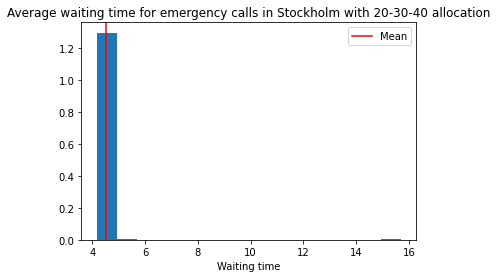

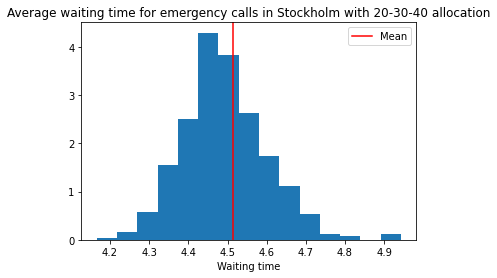

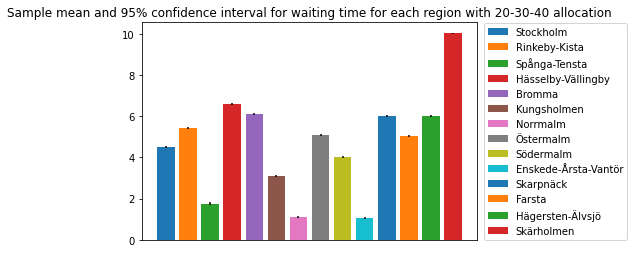

Average number of vacancies for Spånga-Tensta is 26.524 with 95% confidence interval 25.62 - 27.43
Average number of vacancies for Norrmalm is 8.328 with 95% confidence interval 7.05 - 9.61
Average number of vacancies for Enskede-Årsta-Vantör is 2.046 with 95% confidence interval 0.69 - 3.40


In [21]:
#Plot the average waiting time distribution for stockholm
plt.hist(region_data_5["Stockholm"], bins = 15, density = True)
plt.title("Average waiting time for emergency calls in Stockholm with 20-30-40 allocation")
plt.xlabel("Waiting time")
plt.axvline(np.mean(region_data_5["Stockholm"]), label = "Mean", color = "red")
plt.legend()
plt.show()

#plot around the mode
filter_data = np.array(region_data_5["Stockholm"])
filter_data = filter_data[filter_data < 5]
plt.hist(filter_data, bins = 15, density = True)
plt.title("Average waiting time for emergency calls in Stockholm with 20-30-40 allocation")
plt.xlabel("Waiting time")
plt.axvline(np.mean(region_data_5["Stockholm"]), label = "Mean", color = "red")
plt.legend()
plt.show()

#Create plot for the average waiting time with confidence intervals for each region
i = 0

for region in region_data_5.keys():
    
    #Mean
    mean = np.mean(region_data_5[region])
    
    #standard deviation of the population
    std = np.std(region_data_5[region])/np.sqrt(len(region_data_5[region]))

    #Plot errorbars
    plt.bar(i, mean, yerr = std*1.96, label = region)
    
    i += 1
    
plt.xticks([])
plt.legend(loc = [1.02,0])
plt.title("Sample mean and 95% confidence interval for waiting time for each region with 20-30-40 allocation")
plt.show()

for station in station_data_5.keys():
    confint = sts.t.interval(0.95, len(station_data_5[station])-1,
                             loc=np.mean(station_data_5[station]), scale=sts.sem(station_data_5[station]))
    print(f"Average number of vacancies for {station} is {np.mean(station_data_5[station])} with 95% confidence interval {confint[0]:.2f} - {confint[1]:.2f}")

In [22]:
#Slightly skewed allocation towards enskede
station_data_25_30_35 = {
    "Spånga-Tensta": 25,
    "Norrmalm": 30,
    "Enskede-Årsta-Vantör": 35,
}
region_data_6, station_data_6 = run_experiment(area_data, station_data_25_30_35, nr_simulations = nr_sim)

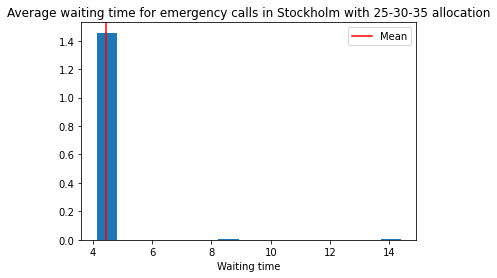

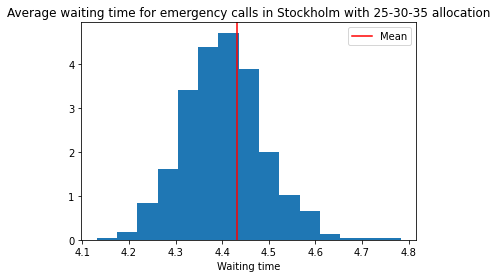

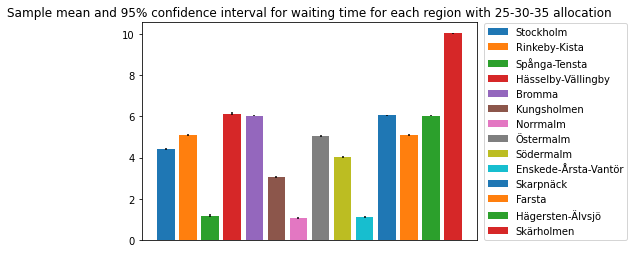

Average number of vacancies for Spånga-Tensta is 6.432 with 95% confidence interval 5.54 - 7.33
Average number of vacancies for Norrmalm is 3.772 with 95% confidence interval 2.36 - 5.18
Average number of vacancies for Enskede-Årsta-Vantör is 6.774 with 95% confidence interval 5.25 - 8.30


In [23]:
#Plot the average waiting time distribution for stockholm
plt.hist(region_data_6["Stockholm"], bins = 15, density = True)
plt.title("Average waiting time for emergency calls in Stockholm with 25-30-35 allocation")
plt.xlabel("Waiting time")
plt.axvline(np.mean(region_data_6["Stockholm"]), label = "Mean", color = "red")
plt.legend()
plt.show()

#plot around the mode
filter_data = np.array(region_data_6["Stockholm"])
filter_data = filter_data[filter_data < 5]
plt.hist(filter_data, bins = 15, density = True)
plt.title("Average waiting time for emergency calls in Stockholm with 25-30-35 allocation")
plt.xlabel("Waiting time")
plt.axvline(np.mean(region_data_6["Stockholm"]), label = "Mean", color = "red")
plt.legend()
plt.show()


#Create plot for the average waiting time with confidence intervals for each region
i = 0

for region in region_data_6.keys():
    
    #Mean
    mean = np.mean(region_data_6[region])
    
    #standard deviation of the population
    std = np.std(region_data_6[region])/np.sqrt(len(region_data_6[region]))

    #Plot errorbars
    plt.bar(i, mean, yerr = std*1.96, label = region)
    
    i += 1
    
plt.xticks([])
plt.legend(loc = [1.02,0])
plt.title("Sample mean and 95% confidence interval for waiting time for each region with 25-30-35 allocation")
plt.show()

for station in station_data_6.keys():
    confint = sts.t.interval(0.95, len(station_data_6[station])-1,
                             loc=np.mean(station_data_6[station]), scale=sts.sem(station_data_6[station]))
    print(f"Average number of vacancies for {station} is {np.mean(station_data_6[station])} with 95% confidence interval {confint[0]:.2f} - {confint[1]:.2f}")

To conclude, a slightly higher allocation towards Enskede results in the most efficient ambulance distribution as it minimize both waiting time and average number of vacancies